In [14]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Normal

In [15]:
# --- Hyperparameters ---
class cfg:
    env_name = "MountainCarContinuous-v0"
    learning_rate = 0.01
    gamma         = 0.99
    hid_dim       = 42
    episodes      = 500
    num_envs      = 10


# --- Create environment ---
envs = [gym.make(cfg.env_name) for _ in range(cfg.num_envs)]
env = gym.make(cfg.env_name)


# --- Policy network ---
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, action_dim, hid_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hid_dim),
            nn.ReLU(),
            # nn.Linear(hid_dim, hid_dim),
            # nn.ReLU(),
            nn.Linear(hid_dim, action_dim),
            nn.Tanh()
        )
        self.log_std = nn.Parameter(torch.ones(action_dim))

    def forward(self, x):
        mean = self.net(x)
        std = torch.exp(self.log_std)
        dist = Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum()
        return action, log_prob

    def act(self, x):
        with torch.no_grad():
            mean = self.net(x)
            return mean

policy = PolicyNet(env.observation_space.shape[0], env.action_space.shape[0], cfg.hid_dim)
optimizer = optim.Adam(policy.parameters(), lr=cfg.learning_rate)

In [ ]:
# --- Function to compute reward-to-go ---
def compute_all_rtg(reward_batch, gamma):
    rtg_batch = []
    for rewards in reward_batch:
        rtg = np.zeros_like(rewards, dtype=np.float32)
        running_add = 0
        for t in reversed(range(len(rewards))):
            running_add = rewards[t] + gamma * running_add
            rtg[t] = running_add
        rtg_batch.append(rtg)
        
    # Normalize across all episodes
    flat = np.concatenate(rtg_batch)
    norm_flat = (flat - flat.mean()) / (flat.std() + 1e-9)
    norm_rtg_batch = []
    idx = 0
    for rewards in reward_batch:
        l = len(rewards)
        norm_rtg_batch.append(torch.tensor(norm_flat[idx:idx+l]).float())
        idx += l
    return norm_rtg_batch

# --- Training loop ---
reward_hist = []

for episode in range(cfg.episodes):
    all_rewards = []
    all_log_probs = []
    episode_rewards = []

    for env_id in range(cfg.num_envs):
        state, _ = envs[env_id].reset()
        rewards = []
        log_probs = []

        while True:
            state_tensor = torch.from_numpy(state).float()
            action, log_prob = policy(state_tensor)
            action_np = action.detach().numpy()
            next_state, reward, done, truncated, _ = envs[env_id].step(action_np)

            position, velocity = next_state
            
            if (velocity > 0 and position > 0.05) or (velocity < 0 and position < -0.05):
                reward += 0.1 * abs(velocity)
            if (velocity > 0 and position > 0.1) or (velocity < 0 and position < -0.1):
                reward += 0.2 * abs(velocity)
            if (velocity > 0 and position > 0.2) or (velocity < 0 and position < -0.2):
                reward += 0.3 * abs(velocity)
            
            if position >= 0.25:
                    reward += 1
            if position <= 0.1:
                    reward -= 1

            rewards.append(reward)
            log_probs.append(log_prob)
            state = next_state

            if done or truncated:
                break

        episode_rewards.append(sum(rewards))
        all_rewards.append(rewards)
        all_log_probs.append(log_probs)

    # Compute reward-to-go and normalize across batch
    rtg_batch = compute_all_rtg(all_rewards, cfg.gamma)

    # Compute loss
    all_loss_terms = []
    for log_probs, rtg in zip(all_log_probs, rtg_batch):
        all_loss_terms.extend([-lp * Gt for lp, Gt in zip(log_probs, rtg)])

    if all_loss_terms:
        loss = torch.stack(all_loss_terms).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Logging
    mean_reward = np.mean(episode_rewards)
    reward_hist.append(mean_reward)
    if episode % 5 == 0:
        print(f"Episode {episode}, mean reward: {mean_reward:.2f}")

for env in envs:
    env.close()

Episode 0, mean reward: -1732.50
Episode 5, mean reward: -1633.06
Episode 10, mean reward: -1512.57
Episode 15, mean reward: -1389.57
Episode 20, mean reward: -1325.96
Episode 25, mean reward: -1421.54
Episode 30, mean reward: -1210.50
Episode 35, mean reward: -1221.55
Episode 40, mean reward: -1069.23
Episode 45, mean reward: -1214.52
Episode 50, mean reward: -1220.52
Episode 55, mean reward: -913.45
Episode 60, mean reward: -924.92
Episode 65, mean reward: -1030.98
Episode 70, mean reward: -859.33
Episode 75, mean reward: -851.07
Episode 80, mean reward: -888.83
Episode 85, mean reward: -686.52
Episode 90, mean reward: -580.25
Episode 95, mean reward: -661.57
Episode 100, mean reward: -607.79
Episode 105, mean reward: -550.96
Episode 110, mean reward: -446.02
Episode 115, mean reward: -445.31
Episode 120, mean reward: -293.64
Episode 125, mean reward: -340.24
Episode 130, mean reward: -278.06
Episode 135, mean reward: -400.30
Episode 140, mean reward: -549.97
Episode 145, mean reward

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\alexs\AppData\Local\Temp\ipykernel_17992\802566352.py:2: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("\sum rewards")


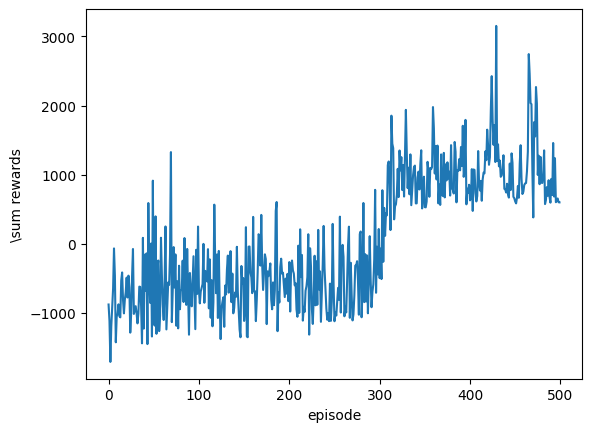

In [ ]:
plt.plot(reward_hist)
plt.ylabel("\sum rewards")
plt.xlabel("episode")
plt.show()

In [18]:
torch.save(policy.state_dict(), 'policy_weights.pth')

In [19]:
loaded_policy = PolicyNet(env.observation_space.shape[0], env.action_space.shape[0], cfg.hid_dim)
loaded_policy.load_state_dict(torch.load('policy_weights.pth'))
loaded_policy.eval()

PolicyNet(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=42, bias=True)
    (1): ReLU()
    (2): Linear(in_features=42, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [24]:
import time

policy.eval()
env = gym.make("MountainCarContinuous-v0", render_mode="human")
state, _ = env.reset()
total_reward = 0

while True:
    env.render()  # open a render window
    time.sleep(0.02)  # slow it down a bit (optional)

    state_tensor = torch.from_numpy(state).float()
    with torch.no_grad():
        action = policy.act(state_tensor).numpy()

    state, reward, done, truncated, _ = env.step(action)
    total_reward += reward
    if done or truncated:
        break

env.close()
print(f"Total reward in evaluation: {total_reward}")

Total reward in evaluation: 93.8353430320906


In [98]:
import importlib
import mountain_car_custom
importlib.reload(mountain_car_custom)

from gymnasium.envs.registration import register

register(
    id='MountainCarContinuous-v0_Custom',
    entry_point='mountain_car_custom:Continuous_MountainCarEnvCustom',
)

In [99]:
import time

policy.eval()
env_custom = gym.make("MountainCarContinuous-v0_Custom", render_mode="human")
state, _ = env_custom.reset()
total_reward = 0

while True:
    env_custom.render()  # open a render window
    time.sleep(0.02)  # slow it down a bit (optional)

    state_tensor = torch.from_numpy(state).float()
    with torch.no_grad():
        action = policy.act(state_tensor).numpy()

    state, reward, done, truncated, _ = env_custom.step(action)
    total_reward += reward
    if done or truncated:
        break

env_custom.close()
print(f"Total reward in evaluation: {total_reward}")

Total reward in evaluation: 92.66119001010895
